In [1]:
from utils.utils import train_model, base_transform, evaluate_model_with_cm, TiffDataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import copy
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from  models.video_classifier import TransformerModel_
from  models.video_classifier import VideoClassifier

In [2]:
num_epochs = 50
patience=None
bands = 10
patch_size = 5
time_idx = 4 #5월초
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [3]:
#val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}
val_filter = lambda x: x >= 3 and (x % 50) in {3, 8, 15, 20, 22, 27, 34, 39, 41, 46}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=6, kernel_size=3):
        super(ResNetClassifier, self).__init__()
        # ResNet18 모델을 기반으로 사용
        self.transform = transform
        self.resnet = models.resnet18(weights=None)  # 사전 훈련 없이 초기화
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=1, bias=False)  # 입력 채널 9개로 변경
        self.resnet.maxpool = nn.Identity()  # 5x5 입력이므로 MaxPooling 제거
        self.resnet.fc = nn.Linear(512, num_classes)  # 마지막 출력 뉴런을 클래스 수에 맞게 변경

    def forward(self, x):
        return self.resnet(x)

In [6]:
class FeedForwardBlock(nn.Module):
    def __init__(self, dim, expand_ratio=4, dropout=0.1):
        super(FeedForwardBlock, self).__init__()
        hidden_dim = dim * expand_ratio
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, dim, expand_ratio=4, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.ffn = FeedForwardBlock(dim, expand_ratio, dropout)
    
    def forward(self, x):
        out = self.norm(x)
        out = self.ffn(out)
        return x + out  # Skip Connection

class DNNClassifier(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=128, output_dim=6, num_layers=10, expand_ratio=4, dropout=0.1):
        super(DNNClassifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(*[ResidualBlock(hidden_dim, expand_ratio, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x


In [7]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=10, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        # Linear layer for embedding input_dim -> embed_dim
        self.input_fc = nn.Linear(input_dim, embed_dim)
        
        # Transformer Encoder Layer 설정 (batch_first=True)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  # 입력의 임베딩 차원
            nhead=num_heads,  # Multi-head Attention의 head 개수
            dropout=dropout,
            batch_first=True  # 배치 차원이 첫 번째로 오도록 설정
        )
        
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers  # Encoder Layer의 수
        )
        
        # 마지막 출력에서 분류를 위한 Linear Layer
        self.fc = nn.Linear(embed_dim, num_classes)
        
        #가중치 초기화
        self._init_weights()
        
    def forward(self, x):
        # 입력을 임베딩 차원으로 변환
        x = self.input_fc(x)
        
        # Transformer Encoder 통과
        transformer_out = self.transformer_encoder(x)
        
        # transformer_out의 마지막 시퀀스에 해당하는 출력을 가져옵니다.
        # (batch, seq_len, embed_dim) -> (batch, embed_dim)
        out = transformer_out[:, -1, :]
        
        # FC Layer를 통한 분류
        out = self.fc(out)
        
        return out
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.TransformerEncoderLayer):
                nn.init.xavier_uniform_(m.linear1.weight)
                nn.init.xavier_uniform_(m.linear2.weight)
                if m.linear1.bias is not None:
                    nn.init.zeros_(m.linear1.bias)
                if m.linear2.bias is not None:
                    nn.init.zeros_(m.linear2.bias)


In [8]:
import torch
import torch.nn.functional as F
import math

def get_gaussian_kernel(kernel_size, sigma):
    """
    2D Gaussian Kernel 생성
    """
    ax = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

class DownsampleWithGaussian:
    def __init__(self, kernel_size: int, sigma: float = None):
        """
        kernel_size: 가우시안 필터 크기
        sigma: 가우시안 필터의 표준편차 (None일 경우 기본값 자동 설정)
        """
        self.kernel_size = kernel_size
        if sigma is None:
            sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8  # 일반적인 디폴트 값
        self.sigma = sigma
        
        # 가우시안 커널 생성
        kernel = get_gaussian_kernel(kernel_size, sigma)
        self.kernel = kernel.view(1, 1, kernel_size, kernel_size)  # (1, 1, K, K)
    
    def __call__(self, x):
        """
        x: Tensor of shape (B, T, H, W)
        Returns: Downsampled Tensor of shape (B, T, H//kernel_size, W//kernel_size)
        """
        B, T, H, W = x.shape
  
        if H % self.kernel_size != 0 or W % self.kernel_size != 0:
            raise ValueError(f"Input size ({H}, {W}) must be divisible by kernel_size {self.kernel_size}")
        
        # 채널 차원 추가 후 Gaussian Blur 적용
        x = x.contiguous().view(B * T, 1, H, W)  # (B*T, 1, H, W)
        x_blurred = F.conv2d(x, self.kernel.to(x.device), stride=self.kernel_size, padding=0)  # (B*T, 1, H//K, W//K)
        
        return x_blurred.view(B, T, H // self.kernel_size, W // self.kernel_size)



## Using Spectral

In [9]:
kernel_size = 5

checkpoints_dir = "./checkpoints/spectral"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir

input.shape = (1,10)

In [10]:
transform = transforms.Compose([
    base_transform(bands, patch_size),
    transforms.Lambda(lambda x: x[:,time_idx].unsqueeze(1)),
    DownsampleWithGaussian(kernel_size, sigma=3),
    transforms.Lambda(lambda x: x.squeeze())
])

# transform = transforms.Compose([
#     base_transform(bands, patch_size),
#     transforms.Lambda(lambda x: x.mean(dim=1, keepdim=True)),
#     DownsampleWithGaussian(kernel_size, sigma=3),
#     transforms.Lambda(lambda x: x.squeeze())
# ])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = lambda box_number: not val_filter(box_number),
            patch_size = patch_size,
            transform=transform
        )

val_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file ="../../data/label_data/species/label_mapping_sampled.csv",
            box_filter_fn = val_filter,
            patch_size = patch_size,
            transform=transform
        )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
model = DNNClassifier().to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [12]:
# 전체 파라미터 수 (학습 가능한 파라미터와 학습 불가능한 파라미터 포함)
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 (requires_grad == True인 파라미터)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("전체 파라미터 수:", total_params)
print("학습 가능한 파라미터 수:", trainable_params)

전체 파라미터 수: 1321862
학습 가능한 파라미터 수: 1321862


Epoch 1/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.33it/s]



Epoch [1/50], Train Loss: 42.2274, Train Accuracy: 0.47, Train f1-score: 0.45 Val Loss: 30.1486, Val Accuracy: 0.49, Val f1-score: 0.45



Epoch 2/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.01it/s]



Epoch [2/50], Train Loss: 19.4173, Train Accuracy: 0.53, Train f1-score: 0.51 Val Loss: 14.9303, Val Accuracy: 0.50, Val f1-score: 0.46



Epoch 3/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 64.50it/s]



Epoch [3/50], Train Loss: 8.8843, Train Accuracy: 0.54, Train f1-score: 0.53 Val Loss: 8.9222, Val Accuracy: 0.44, Val f1-score: 0.37



Epoch 4/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.63it/s]



Epoch [4/50], Train Loss: 4.2153, Train Accuracy: 0.54, Train f1-score: 0.53 Val Loss: 2.2384, Val Accuracy: 0.55, Val f1-score: 0.52



Epoch 5/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.28it/s]



Epoch [5/50], Train Loss: 1.7040, Train Accuracy: 0.57, Train f1-score: 0.56 Val Loss: 1.0659, Val Accuracy: 0.63, Val f1-score: 0.62



Epoch 6/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.16it/s]



Epoch [6/50], Train Loss: 1.0155, Train Accuracy: 0.62, Train f1-score: 0.61 Val Loss: 0.9853, Val Accuracy: 0.62, Val f1-score: 0.59



Epoch 7/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 67.80it/s]



Epoch [7/50], Train Loss: 0.8748, Train Accuracy: 0.66, Train f1-score: 0.65 Val Loss: 0.8871, Val Accuracy: 0.66, Val f1-score: 0.65



Epoch 8/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 63.36it/s]



Epoch [8/50], Train Loss: 0.7996, Train Accuracy: 0.69, Train f1-score: 0.68 Val Loss: 0.8120, Val Accuracy: 0.70, Val f1-score: 0.69



Epoch 9/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.12it/s]



Epoch [9/50], Train Loss: 0.7559, Train Accuracy: 0.71, Train f1-score: 0.70 Val Loss: 0.8748, Val Accuracy: 0.68, Val f1-score: 0.68



Epoch 10/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 65.68it/s]



Epoch [10/50], Train Loss: 0.7216, Train Accuracy: 0.72, Train f1-score: 0.71 Val Loss: 0.8333, Val Accuracy: 0.71, Val f1-score: 0.71



Epoch 11/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 65.74it/s]



Epoch [11/50], Train Loss: 0.6968, Train Accuracy: 0.73, Train f1-score: 0.72 Val Loss: 0.7480, Val Accuracy: 0.73, Val f1-score: 0.72



Epoch 12/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 64.88it/s]



Epoch [12/50], Train Loss: 0.6728, Train Accuracy: 0.74, Train f1-score: 0.73 Val Loss: 0.7691, Val Accuracy: 0.72, Val f1-score: 0.71



Epoch 13/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 65.87it/s]



Epoch [13/50], Train Loss: 0.6603, Train Accuracy: 0.74, Train f1-score: 0.74 Val Loss: 0.8381, Val Accuracy: 0.69, Val f1-score: 0.68



Epoch 14/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.89it/s]



Epoch [14/50], Train Loss: 0.6481, Train Accuracy: 0.75, Train f1-score: 0.74 Val Loss: 0.8607, Val Accuracy: 0.69, Val f1-score: 0.68



Epoch 15/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 63.07it/s]



Epoch [15/50], Train Loss: 0.6306, Train Accuracy: 0.76, Train f1-score: 0.75 Val Loss: 0.8978, Val Accuracy: 0.69, Val f1-score: 0.69



Epoch 16/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.06it/s]



Epoch [16/50], Train Loss: 0.5274, Train Accuracy: 0.80, Train f1-score: 0.79 Val Loss: 0.7799, Val Accuracy: 0.73, Val f1-score: 0.72



Epoch 17/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.63it/s]



Epoch [17/50], Train Loss: 0.5127, Train Accuracy: 0.80, Train f1-score: 0.80 Val Loss: 0.7371, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 18/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.06it/s]



Epoch [18/50], Train Loss: 0.5029, Train Accuracy: 0.81, Train f1-score: 0.80 Val Loss: 0.7715, Val Accuracy: 0.73, Val f1-score: 0.72



Epoch 19/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 65.51it/s]



Epoch [19/50], Train Loss: 0.4935, Train Accuracy: 0.81, Train f1-score: 0.80 Val Loss: 0.8364, Val Accuracy: 0.72, Val f1-score: 0.71



Epoch 20/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 64.21it/s]



Epoch [20/50], Train Loss: 0.4860, Train Accuracy: 0.81, Train f1-score: 0.81 Val Loss: 0.7577, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 21/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.03it/s]



Epoch [21/50], Train Loss: 0.4787, Train Accuracy: 0.81, Train f1-score: 0.81 Val Loss: 0.7859, Val Accuracy: 0.73, Val f1-score: 0.73



Epoch 22/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.04it/s]



Epoch [22/50], Train Loss: 0.4228, Train Accuracy: 0.84, Train f1-score: 0.83 Val Loss: 0.7633, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 23/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.42it/s]



Epoch [23/50], Train Loss: 0.4122, Train Accuracy: 0.84, Train f1-score: 0.84 Val Loss: 0.7871, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 24/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.50it/s]



Epoch [24/50], Train Loss: 0.4072, Train Accuracy: 0.84, Train f1-score: 0.84 Val Loss: 0.7766, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 25/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.16it/s]



Epoch [25/50], Train Loss: 0.3996, Train Accuracy: 0.85, Train f1-score: 0.84 Val Loss: 0.7991, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 26/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.15it/s]



Epoch [26/50], Train Loss: 0.3681, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.8115, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 27/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 59.88it/s]



Epoch [27/50], Train Loss: 0.3624, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.7922, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 28/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.14it/s]



Epoch [28/50], Train Loss: 0.3574, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.8285, Val Accuracy: 0.73, Val f1-score: 0.73



Epoch 29/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 62.02it/s]



Epoch [29/50], Train Loss: 0.3549, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.8272, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 30/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.00it/s]



Epoch [30/50], Train Loss: 0.3365, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.8090, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 31/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 62.19it/s]



Epoch [31/50], Train Loss: 0.3332, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.8119, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 32/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.32it/s]



Epoch [32/50], Train Loss: 0.3307, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.8202, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 33/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 62.37it/s]



Epoch [33/50], Train Loss: 0.3310, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.8184, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 34/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 60.87it/s]



Epoch [34/50], Train Loss: 0.3196, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.8234, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 35/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.03it/s]



Epoch [35/50], Train Loss: 0.3176, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8310, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 36/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:26<00:00, 60.42it/s]



Epoch [36/50], Train Loss: 0.3164, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8297, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 37/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.16it/s]



Epoch [37/50], Train Loss: 0.3144, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8310, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 38/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.06it/s]



Epoch [38/50], Train Loss: 0.3098, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8369, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 39/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.05it/s]



Epoch [39/50], Train Loss: 0.3091, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8445, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 40/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.45it/s]



Epoch [40/50], Train Loss: 0.3096, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8319, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 41/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.03it/s]



Epoch [41/50], Train Loss: 0.3081, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8376, Val Accuracy: 0.74, Val f1-score: 0.74



Epoch 42/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.19it/s]



Epoch [42/50], Train Loss: 0.3054, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8468, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 43/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 60.86it/s]



Epoch [43/50], Train Loss: 0.3047, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8489, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 44/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.84it/s]



Epoch [44/50], Train Loss: 0.3043, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8555, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 45/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.46it/s]



Epoch [45/50], Train Loss: 0.3048, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8489, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 46/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.70it/s]



Epoch [46/50], Train Loss: 0.3036, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8465, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 47/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.12it/s]



Epoch [47/50], Train Loss: 0.3037, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8522, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 48/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.67it/s]



Epoch [48/50], Train Loss: 0.3028, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8468, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 49/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.68it/s]



Epoch [49/50], Train Loss: 0.3031, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.8535, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 50/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:25<00:00, 61.61it/s]



Epoch [50/50], Train Loss: 0.3016, Train Accuracy: 0.89, Train f1-score: 0.88 Val Loss: 0.8523, Val Accuracy: 0.74, Val f1-score: 0.73


train data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 5520/5520 [01:27<00:00, 63.07it/s]


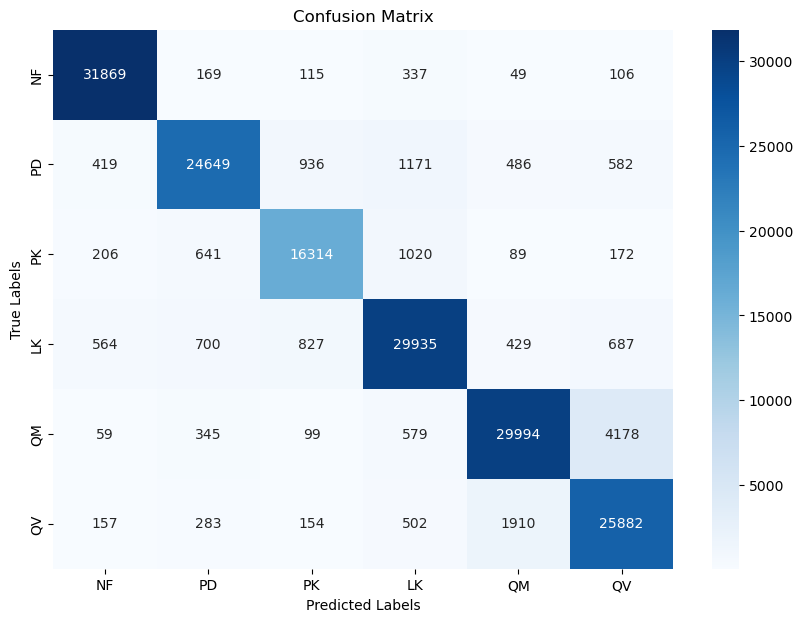

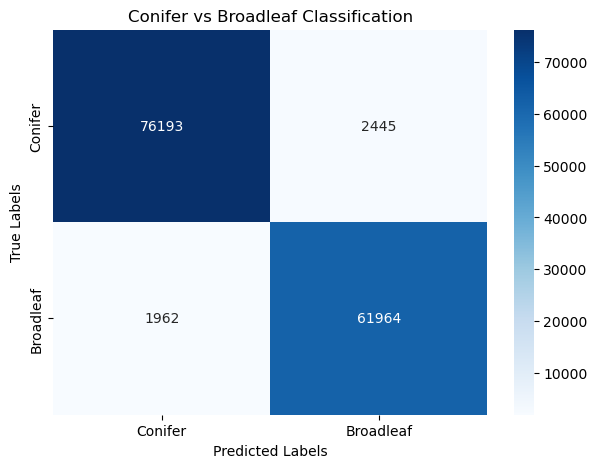

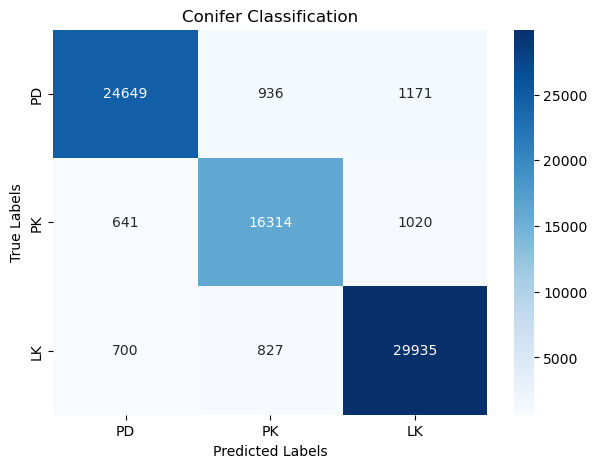

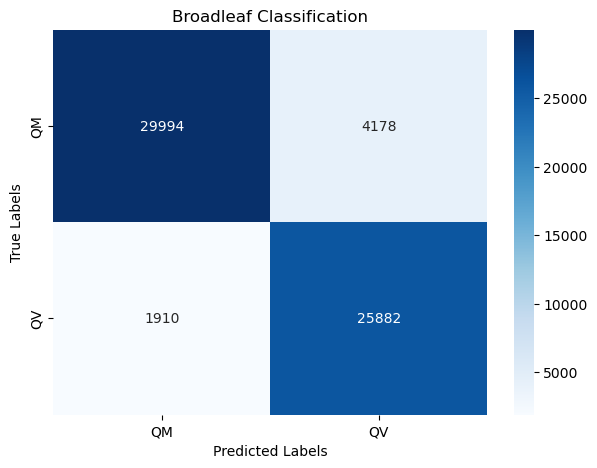


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 1576/1576 [00:24<00:00, 63.26it/s]


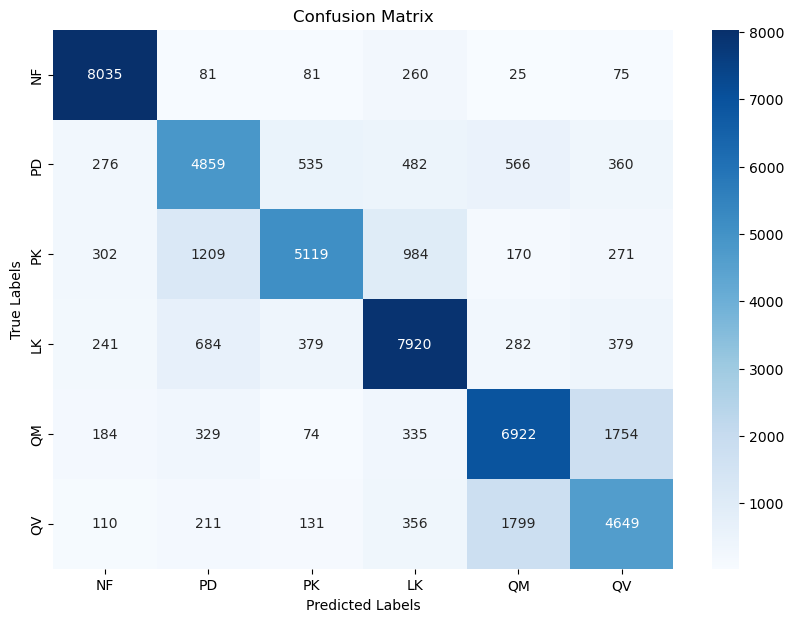

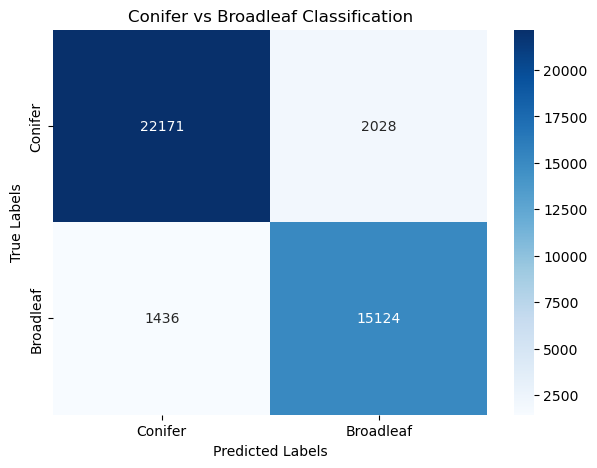

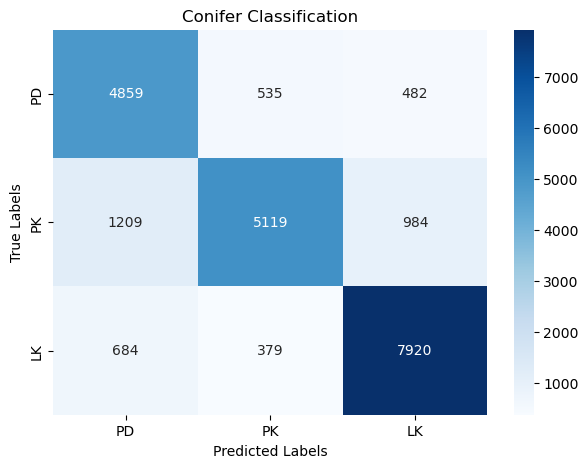

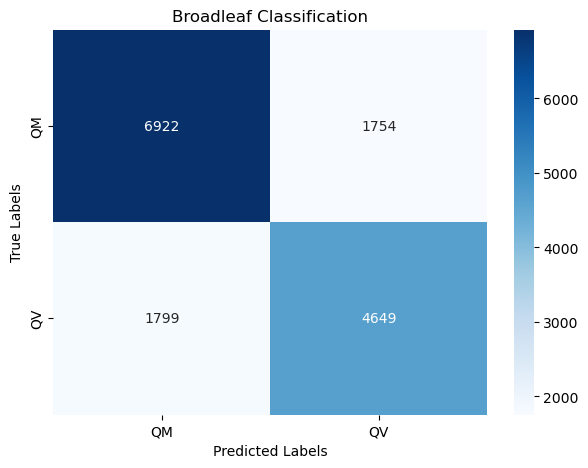

,precision,recall,f1-score,support,task
NF,0.878334,0.938997,0.907653,8557.000000,Overall
PD,0.659026,0.686493,0.672479,7078.000000,Overall
PK,0.810097,0.635506,0.712258,8055.000000,Overall
LK,0.766180,0.801214,0.783305,9885.000000,Overall
QM,0.708931,0.721192,0.715009,9598.000000,Overall
QV,0.620860,0.640711,0.630629,7256.000000,Overall
accuracy,0.743699,0.743699,0.743699,0.743699,Overall
macro avg,0.740571,0.737352,0.736889,50429.000000,Overall
weighted avg,0.745380,0.743699,0.742535,50429.000000,Overall
Conifer,0.939171,0.916195,0.927540,24199.000000,Conifer vs Broadleaf


In [13]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler, patience=patience)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"DNN_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [14]:
# ✅ 메모리 정리
del model
torch.cuda.empty_cache()

# Using Spectral, Spatial

해상도: 2.5m

In [15]:
checkpoints_dir = "./checkpoints/spectral_spatial"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir

In [16]:
transform = transforms.Compose([
    base_transform(bands, patch_size),
    transforms.Lambda(lambda x: x[:,time_idx])
])

train_dataset.transform = transform
val_dataset.transform = transform

In [17]:
model = ResNetClassifier(in_channels=10).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [18]:
# 전체 파라미터 수 (학습 가능한 파라미터와 학습 불가능한 파라미터 포함)
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 (requires_grad == True인 파라미터)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("전체 파라미터 수:", total_params)
print("학습 가능한 파라미터 수:", trainable_params)

전체 파라미터 수: 11175942
학습 가능한 파라미터 수: 11175942


Epoch 1/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:18<00:00, 85.76it/s]



Epoch [1/50], Train Loss: 0.8456, Train Accuracy: 0.66, Train f1-score: 0.65 Val Loss: 1.1619, Val Accuracy: 0.54, Val f1-score: 0.53



Epoch 2/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:18<00:00, 85.61it/s]



Epoch [2/50], Train Loss: 0.6947, Train Accuracy: 0.73, Train f1-score: 0.72 Val Loss: 0.9464, Val Accuracy: 0.65, Val f1-score: 0.64



Epoch 3/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:18<00:00, 84.17it/s]



Epoch [3/50], Train Loss: 0.6276, Train Accuracy: 0.75, Train f1-score: 0.74 Val Loss: 1.1274, Val Accuracy: 0.60, Val f1-score: 0.59



Epoch 4/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.68it/s]



Epoch [4/50], Train Loss: 0.5810, Train Accuracy: 0.77, Train f1-score: 0.77 Val Loss: 1.4720, Val Accuracy: 0.56, Val f1-score: 0.53



Epoch 5/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:17<00:00, 88.08it/s]



Epoch [5/50], Train Loss: 0.5441, Train Accuracy: 0.79, Train f1-score: 0.78 Val Loss: 0.7326, Val Accuracy: 0.73, Val f1-score: 0.72



Epoch 6/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:17<00:00, 88.91it/s]



Epoch [6/50], Train Loss: 0.5171, Train Accuracy: 0.80, Train f1-score: 0.79 Val Loss: 0.7687, Val Accuracy: 0.73, Val f1-score: 0.72



Epoch 7/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:19<00:00, 81.12it/s]



Epoch [7/50], Train Loss: 0.4929, Train Accuracy: 0.81, Train f1-score: 0.80 Val Loss: 0.7965, Val Accuracy: 0.70, Val f1-score: 0.68



Epoch 8/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:18<00:00, 85.39it/s]



Epoch [8/50], Train Loss: 0.4724, Train Accuracy: 0.82, Train f1-score: 0.81 Val Loss: 0.7936, Val Accuracy: 0.71, Val f1-score: 0.70



Epoch 9/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:18<00:00, 83.14it/s]



Epoch [9/50], Train Loss: 0.4539, Train Accuracy: 0.82, Train f1-score: 0.82 Val Loss: 0.7480, Val Accuracy: 0.73, Val f1-score: 0.72



Epoch 10/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 88.42it/s]



Epoch [10/50], Train Loss: 0.3931, Train Accuracy: 0.85, Train f1-score: 0.84 Val Loss: 0.7441, Val Accuracy: 0.75, Val f1-score: 0.75



Epoch 11/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 87.79it/s]



Epoch [11/50], Train Loss: 0.3780, Train Accuracy: 0.85, Train f1-score: 0.85 Val Loss: 0.7155, Val Accuracy: 0.76, Val f1-score: 0.75



Epoch 12/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:19<00:00, 82.21it/s]



Epoch [12/50], Train Loss: 0.3644, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.7260, Val Accuracy: 0.75, Val f1-score: 0.74



Epoch 13/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.20it/s]



Epoch [13/50], Train Loss: 0.3540, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.7919, Val Accuracy: 0.75, Val f1-score: 0.74



Epoch 14/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.60it/s]



Epoch [14/50], Train Loss: 0.3430, Train Accuracy: 0.87, Train f1-score: 0.86 Val Loss: 0.7447, Val Accuracy: 0.76, Val f1-score: 0.75



Epoch 15/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.15it/s]



Epoch [15/50], Train Loss: 0.3357, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.8078, Val Accuracy: 0.74, Val f1-score: 0.73



Epoch 16/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:19<00:00, 81.53it/s]



Epoch [16/50], Train Loss: 0.2982, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.7402, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 17/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 85.91it/s]



Epoch [17/50], Train Loss: 0.2880, Train Accuracy: 0.89, Train f1-score: 0.88 Val Loss: 0.7810, Val Accuracy: 0.76, Val f1-score: 0.75



Epoch 18/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 84.34it/s]



Epoch [18/50], Train Loss: 0.2815, Train Accuracy: 0.89, Train f1-score: 0.89 Val Loss: 0.7482, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 19/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 84.52it/s]



Epoch [19/50], Train Loss: 0.2745, Train Accuracy: 0.89, Train f1-score: 0.89 Val Loss: 0.7903, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 20/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.57it/s]



Epoch [20/50], Train Loss: 0.2536, Train Accuracy: 0.90, Train f1-score: 0.90 Val Loss: 0.7822, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 21/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 88.02it/s]



Epoch [21/50], Train Loss: 0.2493, Train Accuracy: 0.90, Train f1-score: 0.90 Val Loss: 0.7717, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 22/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 84.11it/s]



Epoch [22/50], Train Loss: 0.2424, Train Accuracy: 0.91, Train f1-score: 0.90 Val Loss: 0.8082, Val Accuracy: 0.76, Val f1-score: 0.75



Epoch 23/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.94it/s]



Epoch [23/50], Train Loss: 0.2407, Train Accuracy: 0.91, Train f1-score: 0.90 Val Loss: 0.8011, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 24/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:18<00:00, 86.61it/s]



Epoch [24/50], Train Loss: 0.2285, Train Accuracy: 0.91, Train f1-score: 0.91 Val Loss: 0.8047, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 25/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 87.56it/s]



Epoch [25/50], Train Loss: 0.2246, Train Accuracy: 0.91, Train f1-score: 0.91 Val Loss: 0.8112, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 26/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.89it/s]



Epoch [26/50], Train Loss: 0.2229, Train Accuracy: 0.91, Train f1-score: 0.91 Val Loss: 0.8089, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 27/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 93.90it/s]



Epoch [27/50], Train Loss: 0.2210, Train Accuracy: 0.92, Train f1-score: 0.91 Val Loss: 0.8240, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 28/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.37it/s]



Epoch [28/50], Train Loss: 0.2153, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8201, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 29/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.51it/s]



Epoch [29/50], Train Loss: 0.2127, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8226, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 30/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 96.35it/s]



Epoch [30/50], Train Loss: 0.2104, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8294, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 31/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.19it/s]



Epoch [31/50], Train Loss: 0.2098, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8320, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 32/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.22it/s]



Epoch [32/50], Train Loss: 0.2089, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8118, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 33/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.05it/s]



Epoch [33/50], Train Loss: 0.2052, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8253, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 34/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 95.51it/s]



Epoch [34/50], Train Loss: 0.2048, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8310, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 35/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 93.83it/s]



Epoch [35/50], Train Loss: 0.2059, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8085, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 36/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 93.45it/s]



Epoch [36/50], Train Loss: 0.2039, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8287, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 37/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 92.87it/s]



Epoch [37/50], Train Loss: 0.2026, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8389, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 38/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 90.90it/s]



Epoch [38/50], Train Loss: 0.2025, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8215, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 39/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 96.47it/s]



Epoch [39/50], Train Loss: 0.2021, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8495, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 40/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 96.82it/s]



Epoch [40/50], Train Loss: 0.1993, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8466, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 41/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 96.73it/s]



Epoch [41/50], Train Loss: 0.2012, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8409, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 42/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 93.77it/s]



Epoch [42/50], Train Loss: 0.2021, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8186, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 43/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.49it/s]



Epoch [43/50], Train Loss: 0.2004, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8363, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 44/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 95.75it/s]



Epoch [44/50], Train Loss: 0.1995, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8500, Val Accuracy: 0.76, Val f1-score: 0.75



Epoch 45/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 91.56it/s]



Epoch [45/50], Train Loss: 0.1999, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8254, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 46/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 93.41it/s]



Epoch [46/50], Train Loss: 0.1999, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8461, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 47/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 91.61it/s]



Epoch [47/50], Train Loss: 0.2010, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8288, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 48/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 92.95it/s]



Epoch [48/50], Train Loss: 0.2000, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8293, Val Accuracy: 0.77, Val f1-score: 0.76



Epoch 49/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:17<00:00, 92.44it/s]



Epoch [49/50], Train Loss: 0.2007, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8482, Val Accuracy: 0.76, Val f1-score: 0.76



Epoch 50/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:16<00:00, 94.00it/s]



Epoch [50/50], Train Loss: 0.2013, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.8416, Val Accuracy: 0.76, Val f1-score: 0.76


train data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 5520/5520 [01:00<00:00, 91.42it/s]


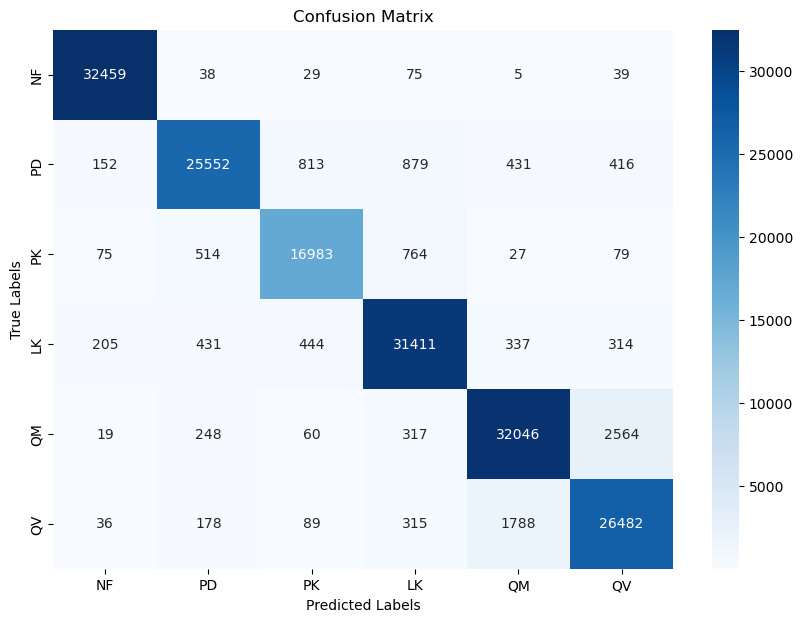

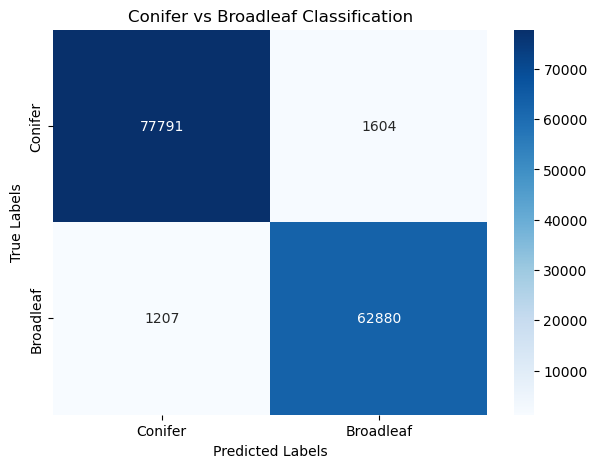

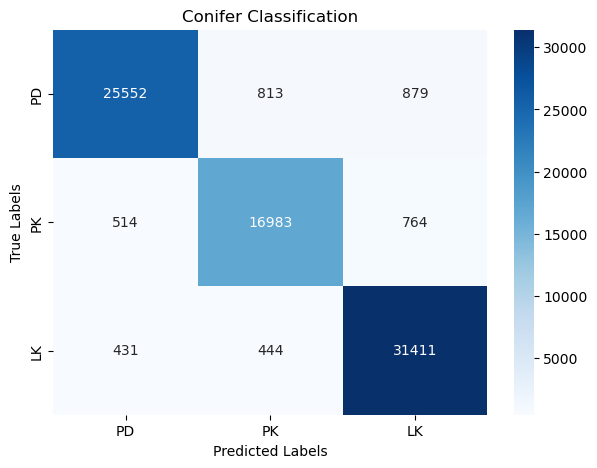

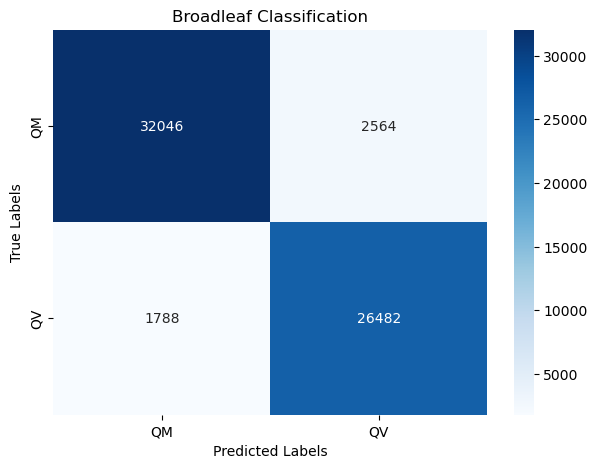


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 1576/1576 [00:17<00:00, 91.10it/s]


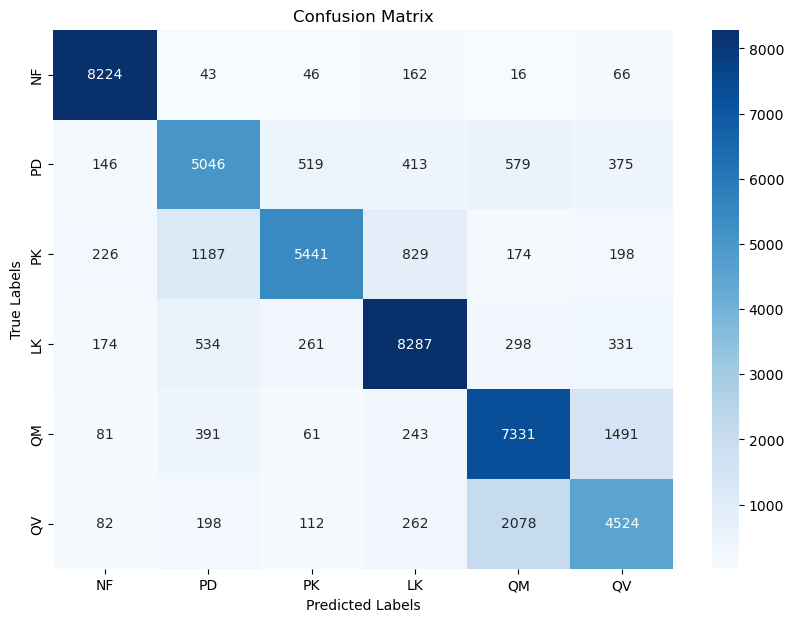

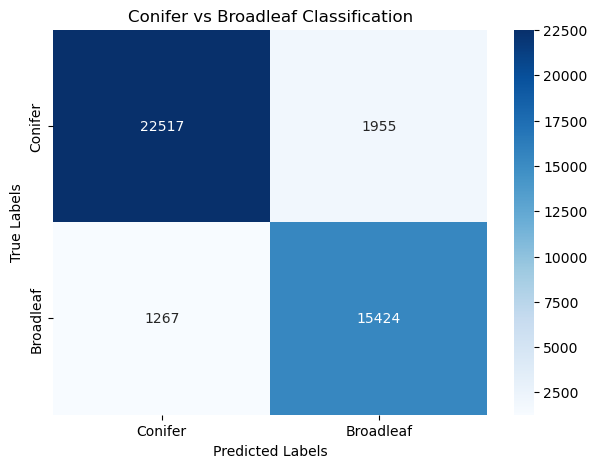

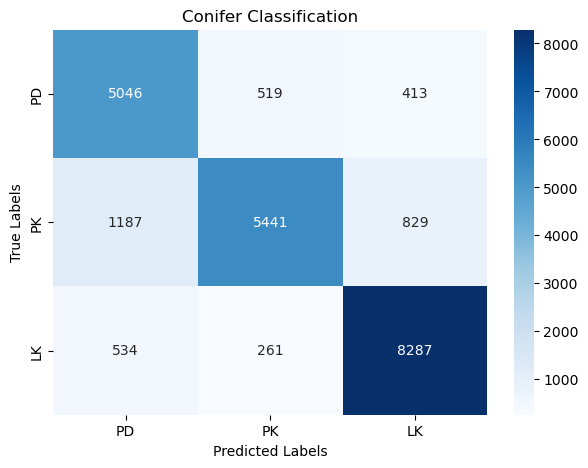

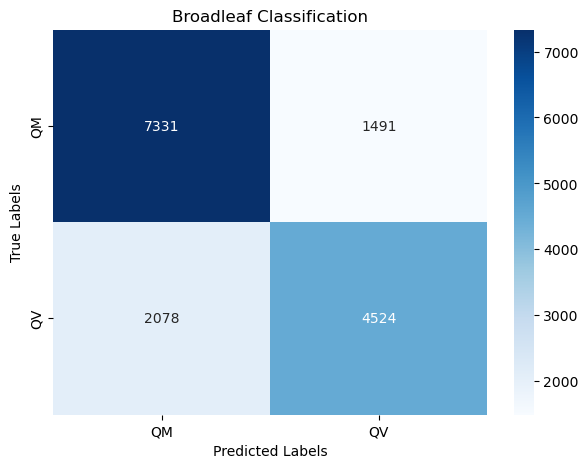

,precision,recall,f1-score,support,task
NF,0.920631,0.961084,0.940423,8557.000000,Overall
PD,0.681984,0.712913,0.697106,7078.000000,Overall
PK,0.844876,0.675481,0.750742,8055.000000,Overall
LK,0.812770,0.838341,0.825357,9885.000000,Overall
QM,0.699790,0.763805,0.730398,9598.000000,Overall
QV,0.647674,0.623484,0.635349,7256.000000,Overall
accuracy,0.770450,0.770450,0.770450,0.770450,Overall
macro avg,0.767954,0.762518,0.763229,50429.000000,Overall
weighted avg,0.772586,0.770450,0.769550,50429.000000,Overall
Conifer,0.946729,0.920113,0.933231,24472.000000,Conifer vs Broadleaf


In [19]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler, patience=patience)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet_{bands}_{patch_size}_{kernel_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [20]:
# ✅ 메모리 정리
del model
torch.cuda.empty_cache()

## Using Spectral, Temporal

(12,10)

In [21]:
kernel_size = 5

checkpoints_dir = "./checkpoints/spectral_temporal"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir

In [22]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (10, 12, 1, 1) → (10, 12)
    x = x.permute(1, 0)  # (10, 12) → (12, 10)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size),
    DownsampleWithGaussian(kernel_size, sigma=3),
    transforms.Lambda(reshape_transform)
])

train_dataset.transform = transform
val_dataset.transform = transform

In [23]:
model =  TransformerClassifier(input_dim=10, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [24]:
# 전체 파라미터 수 (학습 가능한 파라미터와 학습 불가능한 파라미터 포함)
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 (requires_grad == True인 파라미터)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("전체 파라미터 수:", total_params)
print("학습 가능한 파라미터 수:", trainable_params)

전체 파라미터 수: 206534
학습 가능한 파라미터 수: 206534


Epoch 1/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 66.38it/s]



Epoch [1/50], Train Loss: 0.9717, Train Accuracy: 0.60, Train f1-score: 0.58 Val Loss: 0.9079, Val Accuracy: 0.64, Val f1-score: 0.62



Epoch 2/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 66.00it/s]



Epoch [2/50], Train Loss: 0.7157, Train Accuracy: 0.71, Train f1-score: 0.70 Val Loss: 0.7903, Val Accuracy: 0.69, Val f1-score: 0.67



Epoch 3/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 68.30it/s]



Epoch [3/50], Train Loss: 0.6783, Train Accuracy: 0.73, Train f1-score: 0.72 Val Loss: 0.6608, Val Accuracy: 0.75, Val f1-score: 0.74



Epoch 4/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:22<00:00, 69.94it/s]



Epoch [4/50], Train Loss: 0.7368, Train Accuracy: 0.70, Train f1-score: 0.69 Val Loss: 0.6673, Val Accuracy: 0.74, Val f1-score: 0.72



Epoch 5/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:22<00:00, 69.15it/s]



Epoch [5/50], Train Loss: 0.6266, Train Accuracy: 0.75, Train f1-score: 0.74 Val Loss: 0.6389, Val Accuracy: 0.75, Val f1-score: 0.75



Epoch 6/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:22<00:00, 68.79it/s]



Epoch [6/50], Train Loss: 0.5725, Train Accuracy: 0.77, Train f1-score: 0.76 Val Loss: 0.5635, Val Accuracy: 0.79, Val f1-score: 0.78



Epoch 7/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 67.19it/s]



Epoch [7/50], Train Loss: 0.5365, Train Accuracy: 0.79, Train f1-score: 0.78 Val Loss: 0.5564, Val Accuracy: 0.79, Val f1-score: 0.79



Epoch 8/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 66.78it/s]



Epoch [8/50], Train Loss: 0.5132, Train Accuracy: 0.80, Train f1-score: 0.79 Val Loss: 0.5462, Val Accuracy: 0.80, Val f1-score: 0.79



Epoch 9/50 - Validation: 100%|███████████████████████████████████████████████| 1576/1576 [00:23<00:00, 67.90it/s]



Epoch [9/50], Train Loss: 0.5081, Train Accuracy: 0.80, Train f1-score: 0.79 Val Loss: 0.5798, Val Accuracy: 0.79, Val f1-score: 0.78



Epoch 10/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 69.19it/s]



Epoch [10/50], Train Loss: 0.5345, Train Accuracy: 0.79, Train f1-score: 0.78 Val Loss: 0.5913, Val Accuracy: 0.78, Val f1-score: 0.77



Epoch 11/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 68.26it/s]



Epoch [11/50], Train Loss: 0.5149, Train Accuracy: 0.80, Train f1-score: 0.79 Val Loss: 0.5506, Val Accuracy: 0.79, Val f1-score: 0.79



Epoch 12/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 65.89it/s]



Epoch [12/50], Train Loss: 0.4844, Train Accuracy: 0.81, Train f1-score: 0.80 Val Loss: 0.5423, Val Accuracy: 0.81, Val f1-score: 0.80



Epoch 13/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:24<00:00, 64.93it/s]



Epoch [13/50], Train Loss: 0.4718, Train Accuracy: 0.81, Train f1-score: 0.81 Val Loss: 0.5263, Val Accuracy: 0.81, Val f1-score: 0.80



Epoch 14/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 68.24it/s]



Epoch [14/50], Train Loss: 0.4683, Train Accuracy: 0.82, Train f1-score: 0.81 Val Loss: 0.5142, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 15/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 68.69it/s]



Epoch [15/50], Train Loss: 0.4767, Train Accuracy: 0.81, Train f1-score: 0.81 Val Loss: 0.5263, Val Accuracy: 0.81, Val f1-score: 0.80



Epoch 16/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 69.02it/s]



Epoch [16/50], Train Loss: 0.4687, Train Accuracy: 0.82, Train f1-score: 0.81 Val Loss: 0.5393, Val Accuracy: 0.80, Val f1-score: 0.80



Epoch 17/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 70.09it/s]



Epoch [17/50], Train Loss: 0.4566, Train Accuracy: 0.82, Train f1-score: 0.82 Val Loss: 0.5142, Val Accuracy: 0.81, Val f1-score: 0.80



Epoch 18/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 70.10it/s]



Epoch [18/50], Train Loss: 0.4298, Train Accuracy: 0.83, Train f1-score: 0.83 Val Loss: 0.5224, Val Accuracy: 0.81, Val f1-score: 0.80



Epoch 19/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 70.20it/s]



Epoch [19/50], Train Loss: 0.4870, Train Accuracy: 0.81, Train f1-score: 0.80 Val Loss: 0.5148, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 20/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 70.01it/s]



Epoch [20/50], Train Loss: 0.3961, Train Accuracy: 0.85, Train f1-score: 0.84 Val Loss: 0.5046, Val Accuracy: 0.82, Val f1-score: 0.82



Epoch 21/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:23<00:00, 67.87it/s]



Epoch [21/50], Train Loss: 0.3838, Train Accuracy: 0.85, Train f1-score: 0.85 Val Loss: 0.4987, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 22/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 69.23it/s]



Epoch [22/50], Train Loss: 0.3783, Train Accuracy: 0.86, Train f1-score: 0.85 Val Loss: 0.5209, Val Accuracy: 0.82, Val f1-score: 0.82



Epoch 23/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 70.97it/s]



Epoch [23/50], Train Loss: 0.3778, Train Accuracy: 0.86, Train f1-score: 0.85 Val Loss: 0.5175, Val Accuracy: 0.82, Val f1-score: 0.82



Epoch 24/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 71.43it/s]



Epoch [24/50], Train Loss: 0.3797, Train Accuracy: 0.85, Train f1-score: 0.85 Val Loss: 0.5207, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 25/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.43it/s]



Epoch [25/50], Train Loss: 0.3714, Train Accuracy: 0.86, Train f1-score: 0.85 Val Loss: 0.5141, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 26/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.15it/s]



Epoch [26/50], Train Loss: 0.3566, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.5101, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 27/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.06it/s]



Epoch [27/50], Train Loss: 0.3488, Train Accuracy: 0.87, Train f1-score: 0.86 Val Loss: 0.5101, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 28/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.03it/s]



Epoch [28/50], Train Loss: 0.3440, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.5236, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 29/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.73it/s]



Epoch [29/50], Train Loss: 0.3487, Train Accuracy: 0.87, Train f1-score: 0.86 Val Loss: 0.5143, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 30/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.45it/s]



Epoch [30/50], Train Loss: 0.3437, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.5200, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 31/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.15it/s]



Epoch [31/50], Train Loss: 0.3363, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.5187, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 32/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:22<00:00, 71.49it/s]



Epoch [32/50], Train Loss: 0.3342, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.5119, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 33/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.16it/s]



Epoch [33/50], Train Loss: 0.3330, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.5140, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 34/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.44it/s]



Epoch [34/50], Train Loss: 0.3301, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5053, Val Accuracy: 0.83, Val f1-score: 0.83



Epoch 35/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.16it/s]



Epoch [35/50], Train Loss: 0.3314, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5129, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 36/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.82it/s]



Epoch [36/50], Train Loss: 0.3277, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5314, Val Accuracy: 0.82, Val f1-score: 0.82



Epoch 37/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.06it/s]



Epoch [37/50], Train Loss: 0.3294, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5177, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 38/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.38it/s]



Epoch [38/50], Train Loss: 0.3278, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5160, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 39/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.89it/s]



Epoch [39/50], Train Loss: 0.3289, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5188, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 40/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.86it/s]



Epoch [40/50], Train Loss: 0.3267, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5137, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 41/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.17it/s]



Epoch [41/50], Train Loss: 0.3264, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5133, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 42/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.35it/s]



Epoch [42/50], Train Loss: 0.3256, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5126, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 43/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.03it/s]



Epoch [43/50], Train Loss: 0.3235, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5149, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 44/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 71.80it/s]



Epoch [44/50], Train Loss: 0.3244, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5135, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 45/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.53it/s]



Epoch [45/50], Train Loss: 0.3247, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5166, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 46/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.06it/s]



Epoch [46/50], Train Loss: 0.3238, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5145, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 47/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.96it/s]



Epoch [47/50], Train Loss: 0.3211, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.5135, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 48/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.19it/s]



Epoch [48/50], Train Loss: 0.3209, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.5144, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 49/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 72.70it/s]



Epoch [49/50], Train Loss: 0.3230, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.5135, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 50/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:21<00:00, 74.07it/s]



Epoch [50/50], Train Loss: 0.3209, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.5139, Val Accuracy: 0.83, Val f1-score: 0.82


train data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 5520/5520 [01:15<00:00, 72.90it/s]


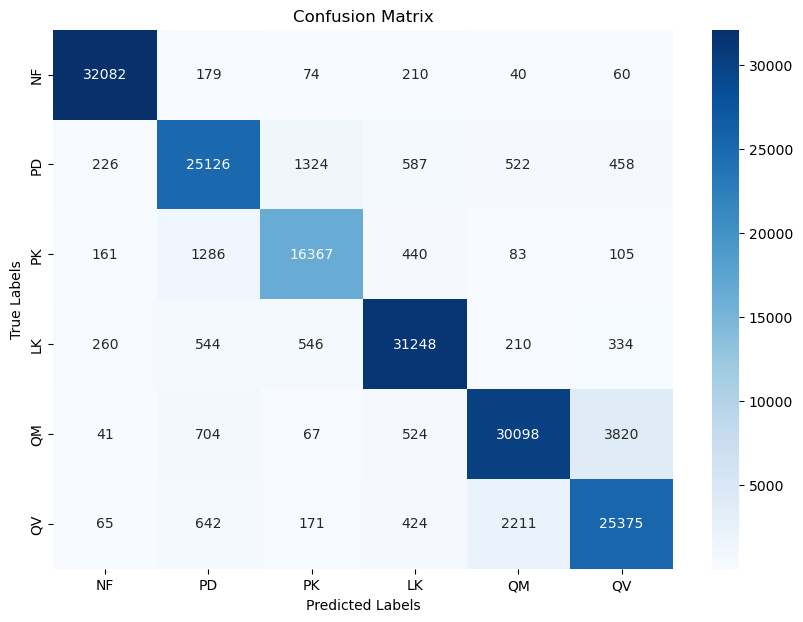

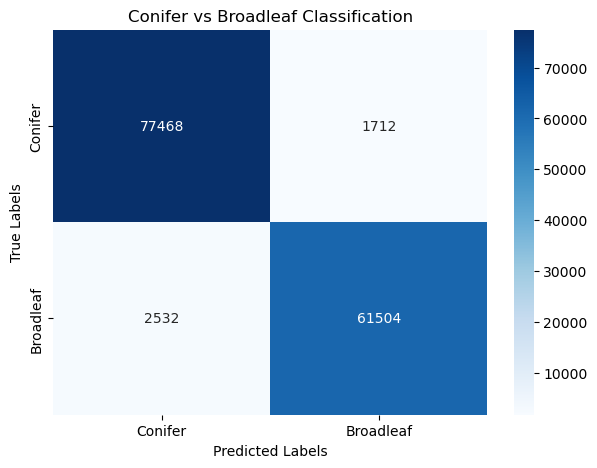

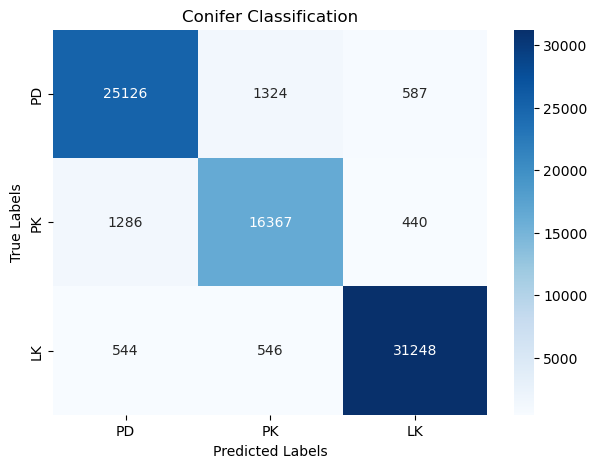

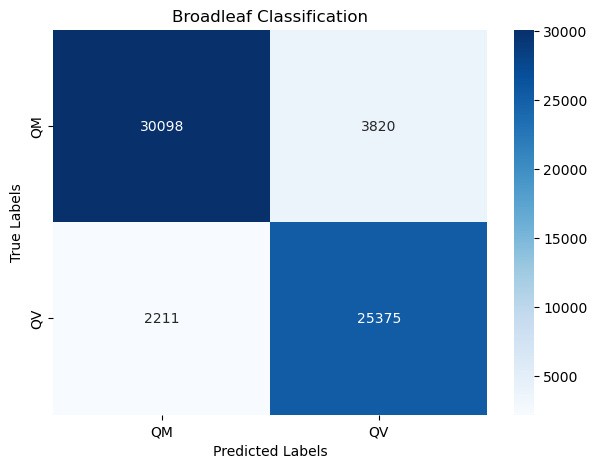


validation data


Evaluation Progress: 100%|███████████████████████████████████████████████████| 1576/1576 [00:21<00:00, 73.29it/s]


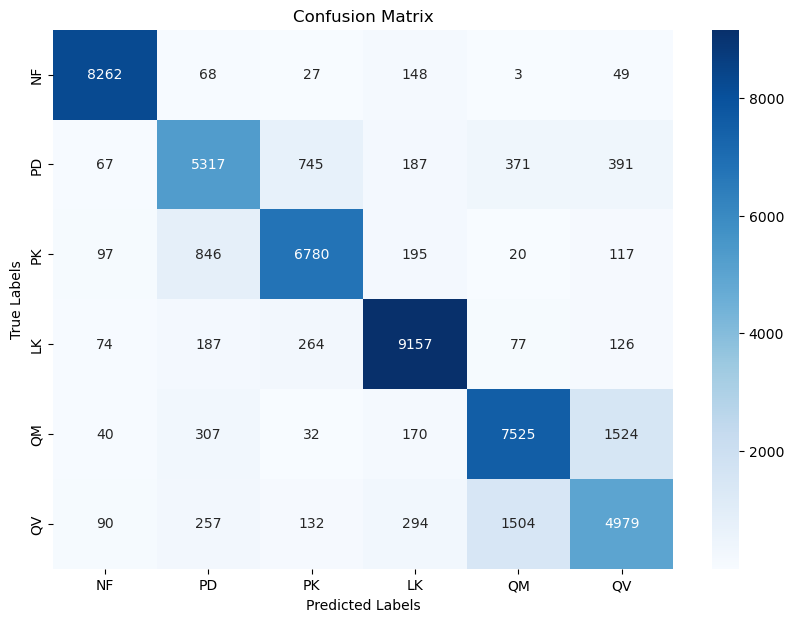

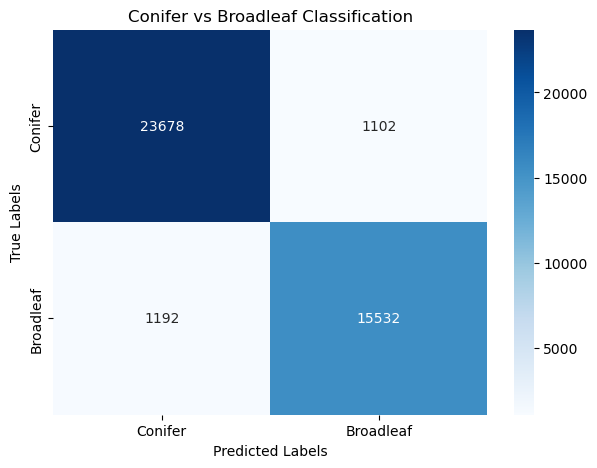

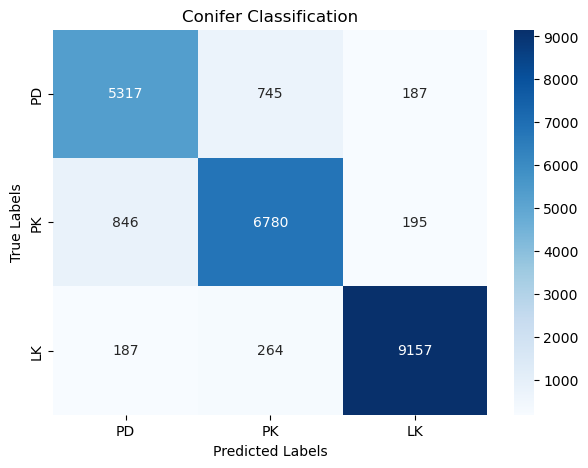

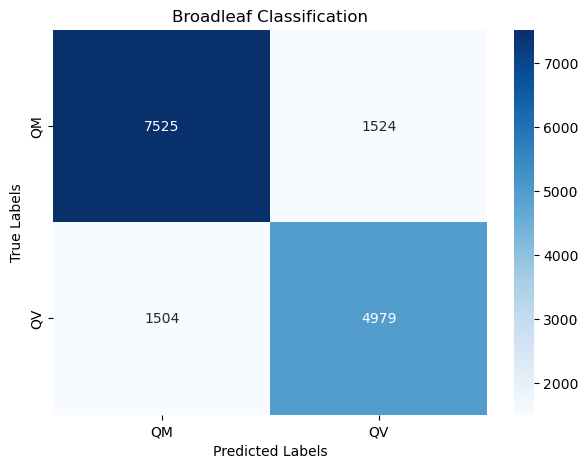

,precision,recall,f1-score,support,task
NF,0.957358,0.965525,0.961424,8557.000000,Overall
PD,0.761530,0.751201,0.756330,7078.000000,Overall
PK,0.849624,0.841713,0.845650,8055.000000,Overall
LK,0.902079,0.926353,0.914055,9885.000000,Overall
QM,0.792105,0.784018,0.788041,9598.000000,Overall
QV,0.692875,0.686191,0.689517,7256.000000,Overall
accuracy,0.833251,0.833251,0.833251,0.833251,Overall
macro avg,0.825928,0.825833,0.825836,50429.000000,Overall
weighted avg,0.832321,0.833251,0.832737,50429.000000,Overall
Conifer,0.952071,0.955529,0.953797,24780.000000,Conifer vs Broadleaf


In [25]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler, patience=patience)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"transformer_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

In [26]:
del model
torch.cuda.empty_cache()

# Using Spectral, Temporal, Spatial

In [27]:
#num_epochs = 100

In [28]:
checkpoints_dir = "./checkpoints/spectral_temporal_spatial"
os.makedirs(checkpoints_dir, exist_ok=True) #checkpoints 저장할 dir

In [29]:
transform = base_transform(bands, patch_size)

train_dataset.transform = transform
val_dataset.transform = transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [30]:
model =  TransformerModel_(patch_size=patch_size).to(device)

# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [31]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler, patience=patience)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"transformer_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

Epoch 1/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:12<00:00, 131.17it/s]



Epoch [1/50], Train Loss: 0.8735, Train Accuracy: 0.67, Train f1-score: 0.66 Val Loss: 0.6122, Val Accuracy: 0.78, Val f1-score: 0.77



Epoch 2/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.21it/s]



Epoch [2/50], Train Loss: 0.5782, Train Accuracy: 0.79, Train f1-score: 0.78 Val Loss: 0.5502, Val Accuracy: 0.80, Val f1-score: 0.79



Epoch 3/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 134.13it/s]



Epoch [3/50], Train Loss: 0.4911, Train Accuracy: 0.82, Train f1-score: 0.82 Val Loss: 0.5149, Val Accuracy: 0.81, Val f1-score: 0.81



Epoch 4/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.11it/s]



Epoch [4/50], Train Loss: 0.4444, Train Accuracy: 0.84, Train f1-score: 0.84 Val Loss: 0.5048, Val Accuracy: 0.82, Val f1-score: 0.81



Epoch 5/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.92it/s]



Epoch [5/50], Train Loss: 0.4114, Train Accuracy: 0.85, Train f1-score: 0.85 Val Loss: 0.4841, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 6/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.86it/s]



Epoch [6/50], Train Loss: 0.3867, Train Accuracy: 0.86, Train f1-score: 0.86 Val Loss: 0.5264, Val Accuracy: 0.82, Val f1-score: 0.82



Epoch 7/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.33it/s]



Epoch [7/50], Train Loss: 0.3630, Train Accuracy: 0.87, Train f1-score: 0.87 Val Loss: 0.4863, Val Accuracy: 0.84, Val f1-score: 0.83



Epoch 8/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:11<00:00, 134.49it/s]



Epoch [8/50], Train Loss: 0.3470, Train Accuracy: 0.88, Train f1-score: 0.87 Val Loss: 0.5103, Val Accuracy: 0.83, Val f1-score: 0.83



Epoch 9/50 - Validation: 100%|██████████████████████████████████████████████| 1576/1576 [00:12<00:00, 130.42it/s]



Epoch [9/50], Train Loss: 0.3332, Train Accuracy: 0.88, Train f1-score: 0.88 Val Loss: 0.5073, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 10/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.40it/s]



Epoch [10/50], Train Loss: 0.2908, Train Accuracy: 0.90, Train f1-score: 0.89 Val Loss: 0.5326, Val Accuracy: 0.83, Val f1-score: 0.82



Epoch 11/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.84it/s]



Epoch [11/50], Train Loss: 0.2767, Train Accuracy: 0.90, Train f1-score: 0.90 Val Loss: 0.4996, Val Accuracy: 0.84, Val f1-score: 0.84



Epoch 12/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.98it/s]



Epoch [12/50], Train Loss: 0.2681, Train Accuracy: 0.91, Train f1-score: 0.90 Val Loss: 0.5098, Val Accuracy: 0.84, Val f1-score: 0.83



Epoch 13/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.17it/s]



Epoch [13/50], Train Loss: 0.2620, Train Accuracy: 0.91, Train f1-score: 0.90 Val Loss: 0.4892, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 14/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:12<00:00, 130.51it/s]



Epoch [14/50], Train Loss: 0.2400, Train Accuracy: 0.92, Train f1-score: 0.91 Val Loss: 0.5370, Val Accuracy: 0.84, Val f1-score: 0.83



Epoch 15/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 131.95it/s]



Epoch [15/50], Train Loss: 0.2346, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.5026, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 16/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.24it/s]



Epoch [16/50], Train Loss: 0.2285, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.5263, Val Accuracy: 0.84, Val f1-score: 0.84



Epoch 17/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 135.25it/s]



Epoch [17/50], Train Loss: 0.2233, Train Accuracy: 0.92, Train f1-score: 0.92 Val Loss: 0.5043, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 18/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 134.33it/s]



Epoch [18/50], Train Loss: 0.2122, Train Accuracy: 0.93, Train f1-score: 0.92 Val Loss: 0.5257, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 19/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.46it/s]



Epoch [19/50], Train Loss: 0.2109, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5216, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 20/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.95it/s]



Epoch [20/50], Train Loss: 0.2077, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5232, Val Accuracy: 0.85, Val f1-score: 0.85



Epoch 21/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.56it/s]



Epoch [21/50], Train Loss: 0.2063, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5297, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 22/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 132.26it/s]



Epoch [22/50], Train Loss: 0.1994, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5348, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 23/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 133.92it/s]



Epoch [23/50], Train Loss: 0.1981, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5336, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 24/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 135.45it/s]



Epoch [24/50], Train Loss: 0.1985, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5371, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 25/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 134.15it/s]



Epoch [25/50], Train Loss: 0.1961, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5271, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 26/50 - Validation: 100%|█████████████████████████████████████████████| 1576/1576 [00:11<00:00, 135.23it/s]



Epoch [26/50], Train Loss: 0.1931, Train Accuracy: 0.93, Train f1-score: 0.93 Val Loss: 0.5345, Val Accuracy: 0.85, Val f1-score: 0.84



Epoch 27/50 - Validation:  94%|██████████████████████████████████████████▍  | 1488/1576 [00:11<00:00, 134.07it/s]


KeyboardInterrupt: 

In [ ]:
# 전체 파라미터 수 (학습 가능한 파라미터와 학습 불가능한 파라미터 포함)
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 (requires_grad == True인 파라미터)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("전체 파라미터 수:", total_params)
print("학습 가능한 파라미터 수:", trainable_params)

cnn

In [ ]:
# 모델 설정
stage_repeats = [2, 3, 4, 3]  # 각 stage에서 ResBlock 반복 횟수
stage_channels = [12, 24, 32, 40]  # 각 stage의 채널 크기
num_classes = 6  # 분류할 클래스 개수

# 모델 생성
model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
# 전체 파라미터 수 (학습 가능한 파라미터와 학습 불가능한 파라미터 포함)
total_params = sum(p.numel() for p in model.parameters())

# 학습 가능한 파라미터 수 (requires_grad == True인 파라미터)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("전체 파라미터 수:", total_params)
print("학습 가능한 파라미터 수:", trainable_params)

In [ ]:
best_model_state, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=scheduler, patience=patience)
torch.save(best_model_state, os.path.join(checkpoints_dir, f"cnn_{bands}_{patch_size}_{num_epochs}.pth"))
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)